<a href="https://colab.research.google.com/github/MatiasSiles/MastercardSalesOptimization/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project only search predict the Mastercard Sales using a dataset more appropriate. I don't Data Wrangling because it is innecesary in this case and i want to focus in the most important

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.graph_objects import Candlestick, Figure

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configuration
df = pd.read_csv("/content/Mastercard Dataset.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.loc[df.Date.dt.year >= 2018]
sales = df[["Date", "Close"]].set_index(df["Date"]).drop("Date", axis=1)

In [3]:
class Forecasting_Mastercard():
  def __init__(self, *, data, data_sales):
    self.data = data
    self.data_sales = data_sales

  class eda():
    def __init__(self):
      df = Forecasting_Mastercard.data
      sales = Forecasting_Mastercard.data_sales

    def stadistical_summary():
      return df.select_dtypes(exclude="datetime").describe().round(2)

    def plot_stock():
      df_plot_stock = df.drop(columns={"Adj Close","Volume"}, axis=1).set_index(df["Date"]).drop("Date", axis=1)

      Figure(data=[
          Candlestick(
              x=df_plot_stock.index, open=df_plot_stock["Open"], high=df_plot_stock["High"],
              low=df_plot_stock["Low"], close=df_plot_stock["Close"])
          ]).show()

    def high_low_volatility():
      df_high_low = df[["Date", "High", "Low"]].set_index(df["Date"]).drop("Date", axis=1)
      df_high_low = df_high_low["High"] - df_high_low["Low"]

      df_high_low.plot(figsize=(15,5))
      plt.show()

    def daily_returns():
      daily_returns = sales.Close.pct_change().dropna()

      fig, axes = plt.subplots(1, 2, figsize=(15,5))
      axes[0].hist(daily_returns)
      axes[1].boxplot(daily_returns)
      fig.suptitle("Relative Performance")
      plt.show()

    def volume_analysis():
      volume_hist = df[["Date","Volume"]].set_index(df["Date"]).drop("Date", axis=1)
      volume_vs_close = df[["Date","Close","Volume"]].set_index(df["Date"]).drop("Date", axis=1)

      fig, axes = plt.subplots(1, 2, figsize=(15,5))
      axes[0].scatter(volume_vs_close["Close"], volume_vs_close["Volume"])
      axes[0].set_xlabel("Close")
      axes[0].set_ylabel("Volume(relative)")

      axes[1].hist(volume_hist) # Millions to relative numbers, e.g: 3 Millions = 0.3
      axes[1].set_xlabel("Volume(relative)")
      axes[1].set_ylabel("Frequency")
      plt.show()

    def movil_trend(*, window):
      sma = sales.rolling(window=window).mean().dropna() # sma = simple movil average

      sma.plot(figsize=(15,5))
      plt.show()

  class models():
    def __init__(self, data):
      df = Forecasting_Mastercard.data
      sales = Forecasting_Mastercard.data_sales

    def forecasting():
      pass


    def detection_anomalies_sales(*, sales, contamination): # detect piks, dips and anomalies
      X = sales # because this model need a 2 dimensional container, not a serie, this is a serie but "[[]]" convert a df

      model = IsolationForest(contamination=contamination, random_state=42) # 5% data will be anomaly
      results = model.fit_predict(X)

      sales["anomalies"] = results
      anomalies = sales[sales["anomalies"] == -1]

      plt.figure(figsize=(15,5))
      sales["Close"].plot()
      plt.scatter(anomalies.index, anomalies["Close"], color='red', label="Anomalies")

      plt.legend()

Forecasting_Mastercard = Forecasting_Mastercard(data=df, data_sales=sales)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdkeaova7/kgzzh7wg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdkeaova7/el5s3efj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33584', 'data', 'file=/tmp/tmpdkeaova7/kgzzh7wg.json', 'init=/tmp/tmpdkeaova7/el5s3efj.json', 'output', 'file=/tmp/tmpdkeaova7/prophet_model47ef5s6f/prophet_model-20250628191510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:15:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:15:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Metrics:
MSE: 203.35
MAE: 10.79


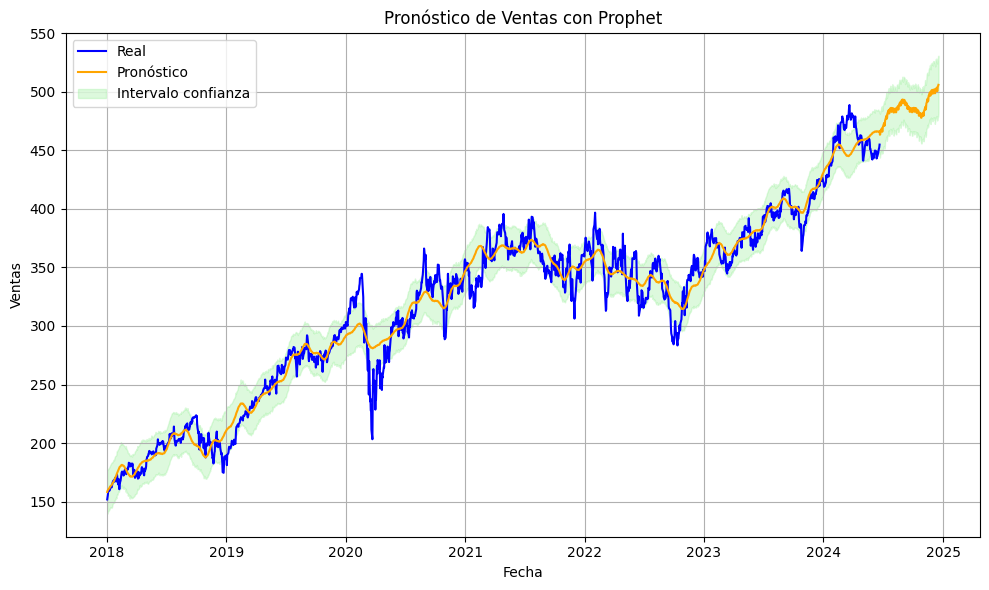

In [4]:
df = sales.reset_index()[["Date", "Close"]]
df.columns = ["ds", "y"]

modelo = Prophet(yearly_seasonality=True)
modelo.fit(df)

futuro = modelo.make_future_dataframe(periods=180)
forecast = modelo.predict(futuro)

plt.figure(figsize=(10, 6))
plt.plot(df["ds"], df["y"], label="Real", color="blue")
plt.plot(forecast["ds"], forecast["yhat"], label="Pronóstico", color="orange")
plt.fill_between(forecast["ds"],
                 forecast["yhat_lower"],
                 forecast["yhat_upper"],
                 color="lightgreen", alpha=0.3, label="Intervalo confianza")

# metrics
print("Metrics:")
print(f"MSE: {mean_squared_error(df['y'], forecast['yhat'].iloc[0:len(df)]):.2f}")
print(f"MAE: {mean_absolute_error(df['y'], forecast['yhat'].iloc[0:len(df)]):.2f}")

plt.title("Pronóstico de Ventas con Prophet")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()